In [141]:


import numpy as np
import sys
import h5py
import platform
import matplotlib
import matplotlib.pyplot as plot
import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

node_name = platform.node()

LOCAL_NODE = 'DESKTOP-L3FA8HC'
if node_name==LOCAL_NODE:
    import matplotlib.pyplot as plot
    import matplotlib.colors as mplcolors
    useGPU=False    
    HOMEDIR = 'F:/projects/pinns_narval/sync/'
    sys.path.append('F:/projects/pinns_local/code/')

from pinns_data_assimilation.lib.file_util import create_directory_if_not_exists
from pinns_data_assimilation.lib.dft import dft

class POD_obj():
    def __init__(self):
        pass


# read the data

base_dir = HOMEDIR+'data/mazi_fixed_grid/'
time_data_dir = 'F:/projects/fixed_cylinder/grid/data/'
figures_dir = 'F:/projects/paper_figures/t010_f2/thesis/'


configFile = h5py.File(base_dir+'configuration.mat','r')
POD_file = h5py.File(base_dir+'POD_data_m16.mat','r')

fs = 10.0

POD_ref = POD_obj()
Phi = np.array(POD_file['Phi'])
Ak = np.array(POD_file['Ak'])
Ak = Ak[0:4082,:] # truncate to the same length as the fourier example
t = np.arange(0,Ak.shape[0])/fs

x = np.array(configFile['X_vec'][0,:])
X_grid = np.array(configFile['X_grid'])
y = np.array(configFile['X_vec'][1,:])
Y_grid = np.array(configFile['Y_grid'])
d = np.array(configFile['cylinderDiameter'])

POD_ref.X_grid = X_grid
POD_ref.Y_grid = Y_grid

phi_xr = np.reshape(Phi[0:x.shape[0],:],[X_grid.shape[0],X_grid.shape[1],Phi.shape[1]])
phi_yr = np.reshape(Phi[x.shape[0]:2*x.shape[0],:],[X_grid.shape[0],X_grid.shape[1],Phi.shape[1]])

POD_ref.phi_x = phi_xr
POD_ref.phi_y  =phi_yr
print(Ak.shape)
POD_ref.Ak = Ak

Ak_hat,f_hat = dft(np.transpose(Ak),fs=fs)
Ak_hat = np.abs(Ak_hat.transpose())/Ak.shape[0]
Ak_hat = 2*Ak_hat[0:Ak.shape[0]//2,:]#+Ak_hat[Ak.shape[1]:-1:Ak.shape[1]//2]
f_hat = f_hat[0:Ak.shape[0]//2]

Ak_hat[0,:]=np.NaN # remove the zero frequency because it is approximately meps
print(Ak_hat.shape)
print(f_hat.shape)
POD_ref.Ak_hat = Ak_hat

# load the assimilated field and compute the POD

n_LOM = 12 # number of POD modes saved
POD_ref.phi_x = POD_ref.phi_x[:,:,0:n_LOM]
POD_ref.phi_y = POD_ref.phi_y[:,:,0:n_LOM]
cylinder_mask = (np.power(np.power(X_grid,2)+np.power(Y_grid,2),0.5)<(0.5*d))
POD_ref.phi_x[cylinder_mask,:]=np.NaN
POD_ref.phi_y[cylinder_mask,:]=np.NaN


from pinns_data_assimilation.lib.decomposition import POD

assimilated_data_dir = 'F:/projects/paper_figures/t010_f2/data/'

POD_as = []
S_star = [1,2,4,8,16,32]
for S in S_star:

    POD_as.append(POD_obj())

# compute the arbitrary phase offsets between mode pairs
n_Pairs = np.int64(n_LOM/2)
theta_p = np.zeros([len(S_star),n_Pairs]) # mode phase angle
theta_m = (np.pi/2)*np.ones([len(S_star),n_Pairs]) # angle between modes in pair, generally +p/2
# some are flipped
theta_m[0,4:6]=-np.pi/2
theta_m[1,4:6]=-np.pi/2
theta_m[2,4:6]=-np.pi/2
theta_m[3,4:6]=-np.pi/2
theta_m[4,3]=-np.pi/2
theta_m[4,5]=-np.pi/2
theta_m[5,3]=-np.pi/2


from scipy.optimize import minimize       

# now do the assimilated fields
for iS in range(len(S_star)):
    S_i = S_star[iS]
    # first load the asimialted velocity
    if S_i>1:
        assimilatedFile =  h5py.File(assimilated_data_dir+'rec_pinn_S'+str(S_i)+'_c5.h5','r')
    else:
        assimilatedFile =  h5py.File(assimilated_data_dir+'rec_pinn_S0_c5.h5','r')
    ux_rec = np.array(assimilatedFile['ux']) # should be the unsteady velocity, it includes the mean field
    uy_rec = np.array(assimilatedFile['uy'])
    p_rec = np.array(assimilatedFile['p'])

    # cylinder mask
    cylinder_mask = (np.power(np.power(X_grid,2)+np.power(Y_grid,2),0.5)<(0.5*d))

    print(ux_rec.shape)
    print(p_rec.shape)
    ux_rec_mean = np.mean(ux_rec,axis=1) # comput the mean
    uy_rec_mean = np.mean(uy_rec,axis=1)
    # compute the temp quantities
    temp_ux = ux_rec_mean
    temp_uy = uy_rec_mean
    temp_ux_grid = np.reshape(ux_rec_mean,X_grid.shape)
    temp_uy_grid = np.reshape(uy_rec_mean,X_grid.shape)


    ux_rec = ux_rec - np.reshape(ux_rec_mean,[ux_rec_mean.shape[0],1])
    uy_rec = uy_rec - np.reshape(uy_rec_mean,[ux_rec_mean.shape[0],1])
    # we dont need to compute the fluctuating pressure because we calibrate using linear regression
    ux_rec[cylinder_mask.ravel(),:] = 0.0
    uy_rec[cylinder_mask.ravel(),:] = 0.0
 
    #plot.figure(1)
    #plot.contourf(X_grid,Y_grid,np.reshape(ux_rec[:,0],X_grid.shape))
    #plot.colorbar()
    #plot.set_cmap('bwr')
    #plot.show()
  

    # compute the POD of the downsampled field
    U_pod = np.concatenate((ux_rec,uy_rec),axis=0)

    Phi, Lambda, Ak = POD(U_pod)

    Phi = Phi[:,0:n_LOM]
    Ak = Ak[:,0:n_LOM]

    # create the custom phi matrix, per the notation of Noack ISSM slides
    # grid version
    POD_as[iS].phi_x = np.reshape(Phi[0:(temp_ux_grid.size),:],[temp_ux_grid.shape[0],temp_ux_grid.shape[1],n_LOM])
    POD_as[iS].phi_y = np.reshape(Phi[(temp_ux_grid.size):2*(temp_ux_grid.size),:],[temp_ux_grid.shape[0],temp_ux_grid.shape[1],n_LOM])

    # create the custom Ak matrix per notation of noack that includes a ones vector along the mean

    POD_as[iS].Ak = Ak

    Ak_hat,f_hat = dft(np.transpose(Ak),fs=fs)
    Ak_hat = np.abs(Ak_hat.transpose())/Ak.shape[0]
    Ak_hat = 2*Ak_hat[0:Ak.shape[0]//2,:]#+Ak_hat[Ak.shape[1]:-1:Ak.shape[1]//2]
    f_hat = f_hat[0:Ak.shape[0]//2]

    Ak_hat[0,:]=np.NaN # remove the zero frequency because it is approximately meps
    POD_as[iS].Ak_hat = Ak_hat

    POD_as[iS].X_grid = X_grid
    POD_as[iS].Y_grid = Y_grid

    
    POD_as[iS].phi_x_rot = np.zeros(POD_as[iS].phi_x.shape)
    POD_as[iS].phi_y_rot = np.zeros(POD_as[iS].phi_y.shape)
    for p_i in range(n_Pairs):
        # find the phase angle to align the reference dataset
        fun=lambda theta: np.nansum(np.power((np.cos(theta)*POD_as[iS].phi_x[:,:,2*p_i]+np.sin(theta)*POD_as[iS].phi_x[:,:,2*p_i+1])-POD_ref.phi_x[:,:,2*p_i],2.0)+np.power((np.cos(theta+theta_m[iS,p_i])*POD_as[iS].phi_x[:,:,2*p_i]+np.sin(theta+theta_m[iS,p_i])*POD_as[iS].phi_x[:,:,2*p_i+1])-POD_ref.phi_x[:,:,2*p_i+1],2.0)+np.power((np.cos(theta)*POD_as[iS].phi_y[:,:,2*p_i]+np.sin(theta)*POD_as[iS].phi_y[:,:,2*p_i+1])-POD_ref.phi_y[:,:,2*p_i],2.0)+np.power((np.cos(theta+theta_m[iS,p_i])*POD_as[iS].phi_y[:,:,2*p_i]+np.sin(theta+theta_m[iS,p_i])*POD_as[iS].phi_y[:,:,2*p_i+1])-POD_ref.phi_y[:,:,2*p_i+1],2.0),axis=(0,1))
        opt_result = minimize(fun,0.0,tol=1E-14)
        theta_p[iS,p_i]= opt_result.x[0]
        # save the rotated mode
        POD_as[iS].phi_x_rot[:,:,2*p_i] = np.cos(theta_p[iS,p_i])*POD_as[iS].phi_x[:,:,2*p_i]+np.sin(theta_p[iS,p_i])*POD_as[iS].phi_x[:,:,2*p_i+1]
        POD_as[iS].phi_x_rot[:,:,2*p_i+1] = np.cos(theta_p[iS,p_i]+theta_m[iS,p_i])*POD_as[iS].phi_x[:,:,2*p_i]+np.sin(theta_p[iS,p_i]+theta_m[iS,p_i])*POD_as[iS].phi_x[:,:,2*p_i+1]
        POD_as[iS].phi_y_rot[:,:,2*p_i] = np.cos(theta_p[iS,p_i])*POD_as[iS].phi_y[:,:,2*p_i]+np.sin(theta_p[iS,p_i])*POD_as[iS].phi_y[:,:,2*p_i+1]
        POD_as[iS].phi_y_rot[:,:,2*p_i+1] = np.cos(theta_p[iS,p_i]+theta_m[iS,p_i])*POD_as[iS].phi_y[:,:,2*p_i]+np.sin(theta_p[iS,p_i]+theta_m[iS,p_i])*POD_as[iS].phi_y[:,:,2*p_i+1]
    
    

(4082, 16)
(2041, 16)
(2041,)
(77441, 4082)
(77441, 4082)
(77441, 4082)
(77441, 4082)
(77441, 4082)
(77441, 4082)
(77441, 4082)
(77441, 4082)
(77441, 4082)
(77441, 4082)
(77441, 4082)
(77441, 4082)


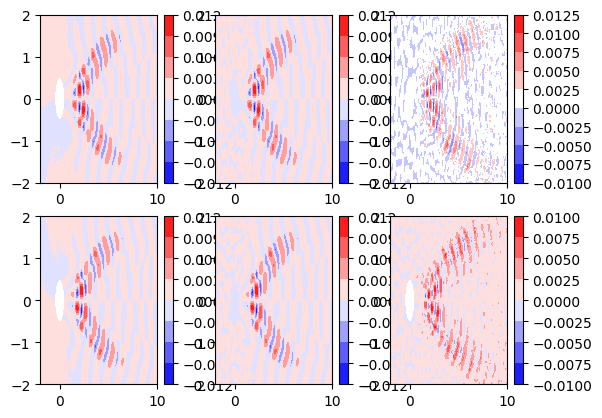

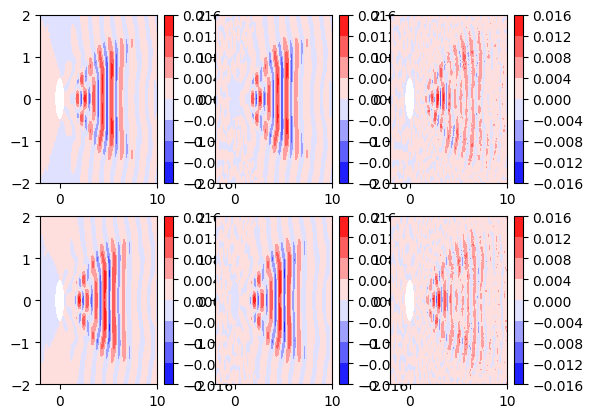

In [142]:
iS = 0
p_i = 4

norm_phi_x = np.nanmax(POD_ref.phi_x[:,:,2*p_i])
norm_phi_y = np.nanmax(POD_ref.phi_y[:,:,2*p_i])

if True:
    plot.figure(1)
    plot.subplot(2,3,1)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_ref.phi_x[:,:,2*p_i])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,2)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_as[iS].phi_x_rot[:,:,2*p_i])
    plot.colorbar()
    plot.set_cmap('bwr')

    plot.subplot(2,3,3)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,(POD_as[iS].phi_x_rot[:,:,2*p_i]-POD_ref.phi_x[:,:,2*p_i])/norm_phi_x)
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,4)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_ref.phi_x[:,:,2*p_i+1])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,5)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_as[iS].phi_x_rot[:,:,2*p_i+1])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,6)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,(POD_as[iS].phi_x_rot[:,:,2*p_i+1]-POD_ref.phi_x[:,:,2*p_i+1])/norm_phi_x)
    plot.colorbar()
    plot.set_cmap('bwr')
    plot.show()


    plot.figure(1)
    plot.subplot(2,3,1)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_ref.phi_y[:,:,2*p_i])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,2)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_as[iS].phi_y_rot[:,:,2*p_i])
    plot.colorbar()
    plot.set_cmap('bwr')

    plot.subplot(2,3,3)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,(POD_as[iS].phi_y_rot[:,:,2*p_i]-POD_ref.phi_y[:,:,2*p_i])/norm_phi_y)
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,4)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_ref.phi_y[:,:,2*p_i+1])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,5)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_as[iS].phi_y_rot[:,:,2*p_i+1])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,6)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,(POD_as[iS].phi_y_rot[:,:,2*p_i+1]-POD_ref.phi_y[:,:,2*p_i+1])/norm_phi_y)
    plot.colorbar()
    plot.set_cmap('bwr')
    plot.show()

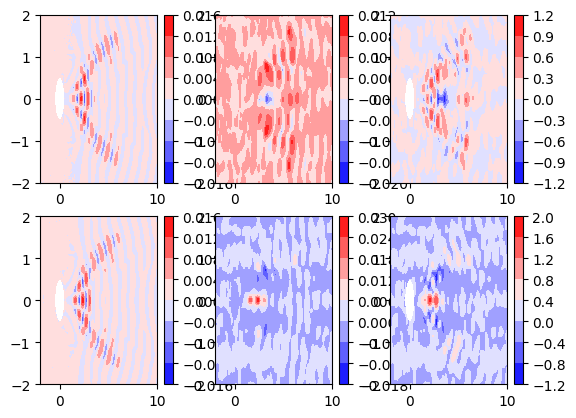

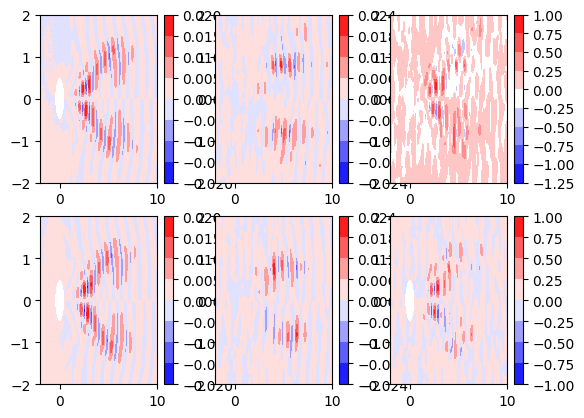

In [140]:
iS = 5
p_i = 5
temp_theta_m = np.pi/2

fun=lambda theta: np.nansum(np.power((np.cos(theta)*POD_as[iS].phi_x[:,:,2*p_i]+np.sin(theta)*POD_as[iS].phi_x[:,:,2*p_i+1])-POD_ref.phi_x[:,:,2*p_i],2.0)+np.power((np.cos(theta+temp_theta_m)*POD_as[iS].phi_x[:,:,2*p_i]+np.sin(theta+temp_theta_m)*POD_as[iS].phi_x[:,:,2*p_i+1])-POD_ref.phi_x[:,:,2*p_i+1],2.0)+np.power((np.cos(theta)*POD_as[iS].phi_y[:,:,2*p_i]+np.sin(theta)*POD_as[iS].phi_y[:,:,2*p_i+1])-POD_ref.phi_y[:,:,2*p_i],2.0)+np.power((np.cos(theta+temp_theta_m)*POD_as[iS].phi_y[:,:,2*p_i]+np.sin(theta+temp_theta_m)*POD_as[iS].phi_y[:,:,2*p_i+1])-POD_ref.phi_y[:,:,2*p_i+1],2.0),axis=(0,1))
opt_result = minimize(fun,0,tol=1E-16)
temp_theta_p= opt_result.x[0]



# save the rotated mode
temp_phi_x_rot = np.zeros((POD_as[iS].phi_x.shape[0],POD_as[iS].phi_x.shape[1],2))
temp_phi_y_rot = np.zeros((POD_as[iS].phi_x.shape[0],POD_as[iS].phi_x.shape[1],2))
temp_phi_x_rot[:,:,0] = np.cos(temp_theta_p)*POD_as[iS].phi_x[:,:,2*p_i]+np.sin(temp_theta_p)*POD_as[iS].phi_x[:,:,2*p_i+1]
temp_phi_x_rot[:,:,1] = np.cos(temp_theta_p+temp_theta_m)*POD_as[iS].phi_x[:,:,2*p_i]+np.sin(temp_theta_p+temp_theta_m)*POD_as[iS].phi_x[:,:,2*p_i+1]
temp_phi_y_rot[:,:,0] = np.cos(temp_theta_p)*POD_as[iS].phi_y[:,:,2*p_i]+np.sin(temp_theta_p)*POD_as[iS].phi_y[:,:,2*p_i+1]
temp_phi_y_rot[:,:,1] = np.cos(temp_theta_p+temp_theta_m)*POD_as[iS].phi_y[:,:,2*p_i]+np.sin(temp_theta_p+temp_theta_m)*POD_as[iS].phi_y[:,:,2*p_i+1]


norm_phi_x = np.nanmax(POD_ref.phi_x[:,:,2*p_i])
norm_phi_y = np.nanmax(POD_ref.phi_y[:,:,2*p_i])

if True:
    plot.figure(1)
    plot.subplot(2,3,1)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_ref.phi_x[:,:,2*p_i])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,2)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,temp_phi_x_rot[:,:,0])
    plot.colorbar()
    plot.set_cmap('bwr')

    plot.subplot(2,3,3)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,(temp_phi_x_rot[:,:,0]-POD_ref.phi_x[:,:,2*p_i])/norm_phi_x)
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,4)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_ref.phi_x[:,:,2*p_i+1])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,5)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,temp_phi_x_rot[:,:,1])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,6)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,(temp_phi_x_rot[:,:,1]-POD_ref.phi_x[:,:,2*p_i+1])/norm_phi_x)
    plot.colorbar()
    plot.set_cmap('bwr')
    plot.show()


    plot.figure(1)
    plot.subplot(2,3,1)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_ref.phi_y[:,:,2*p_i])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,2)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,temp_phi_y_rot[:,:,0])
    plot.colorbar()
    plot.set_cmap('bwr')

    plot.subplot(2,3,3)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,(temp_phi_y_rot[:,:,0]-POD_ref.phi_y[:,:,2*p_i])/norm_phi_y)
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,4)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,POD_ref.phi_y[:,:,2*p_i+1])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,5)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,temp_phi_y_rot[:,:,1])
    plot.colorbar()
    plot.set_cmap('bwr')


    plot.subplot(2,3,6)
    plot.contourf(POD_ref.X_grid,POD_ref.Y_grid,(temp_phi_y_rot[:,:,1]-POD_ref.phi_y[:,:,2*p_i+1])/norm_phi_y)
    plot.colorbar()
    plot.set_cmap('bwr')
    plot.show()


In [151]:


if False:
    plot.figure(1)
    plot.subplot(2,1,1)
    plot.xlim([0,20])
    plot.plot(t,Ak[:,0])
    plot.plot(t,Ak[:,1],'r')
    plot.subplot(2,1,2)
    plot.plot(f_hat,Ak_hat[:,0])
    plot.plot(f_hat,Ak_hat[:,1],'r')
    plot.yscale('log')
    plot.show()
    exit()


def timeplot_line(fig,mid,plot_tuple):
    Ak_1,Ak_2,label1,label2,subplot_label = plot_tuple

    timeplot_x_ticks = [0,5,10,15,20]

    # compute the DFT of the two signals
    inner.append(gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=mid,wspace=0.0,hspace=0.1))
    ax = plot.Subplot(fig,inner[len(inner)-1][0])
    axes.append(ax)
    caxes.append([])

    # plot
    ax.plot(t,Ak_1,'k',linewidth=0.5)
    ax.plot(t,Ak_2,'r',linewidth=0.5)
    ax.set_xlim([0,20])
    ax.set_xticks(timeplot_x_ticks)
    ax.text(7.5,1.2,label1,fontsize=8,color='black')
    ax.text(5.5,1.2,label2,fontsize=8,color='red')
    ax.text(-1.85,1.45,subplot_label,fontsize=8)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    fig.add_subplot(ax)

def spectrumplot_line(fig,mid,plot_tuple,x_label=False,xticklabels=False):
    Ak_hat1,Ak_hat2,label1,label2 = plot_tuple

    MAX_Ak_hat = np.nanmax([np.nanmax(Ak_hat1),np.nanmax(Ak_hat2)])
    MIN_Ak_hat = np.nanmin([np.nanmin(Ak_hat1),np.nanmin(Ak_hat2)])

    frequency_plot_x_ticks = [0,1,2,3,4,5]
    frequency_plot_y_ticks = np.power(10,np.arange(np.floor(np.log10(MIN_Ak_hat))-1,np.ceil(np.log10(MAX_Ak_hat)))+1)

    # compute the DFT of the two signals
    inner.append(gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=mid,wspace=0.0,hspace=0.1,width_ratios=[0.2,0.8]))
    ax = plot.Subplot(fig,inner[len(inner)-1][1])
    axes.append(ax)
    caxes.append([])

    
    # plot
    ax.plot(f_hat,Ak_hat1,'k',linewidth=0.5)
    ax.plot(f_hat,Ak_hat2,'r',linewidth=0.5)
    ax.set_ylim([frequency_plot_y_ticks[0],frequency_plot_y_ticks[-1]])
    ax.set_yscale('log')
    ax.text(3,frequency_plot_y_ticks[-1]/10.0,label1,fontsize=8,color='black')
    ax.text(3,frequency_plot_y_ticks[-1]/100.0,label2,fontsize=8,color='red')
    ax.text(1,frequency_plot_y_ticks[-1]/10.0,letter_labels[len(inner)-1],fontsize=8)
    ax.set_xticks(frequency_plot_x_ticks)
    ax.set_yticks(frequency_plot_y_ticks)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    if x_label:
        ax.set_xlabel('$fD/U_{\infty}$',fontsize=8,labelpad=-1)
    if xticklabels:
        ax.xaxis.set_tick_params(labelbottom=True)
    else:
        ax.xaxis.set_tick_params(labelbottom=False)
    fig.add_subplot(ax)


from pinns_data_assimilation.lib.colormaps import dual_log_cmaps
cmap1,cmap2,cmap3 = dual_log_cmaps()

def contour_err_wcbar(fig,mid,plot_tuple,ylabel=True,xlabel=False,xtick_label=False,ytick_label=True):
    field,field_label,scale = plot_tuple

    inner.append(gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=mid,wspace=0.01,hspace=0.1,width_ratios=[0.97,0.03]))
    ax = plot.Subplot(fig,inner[len(inner)-1][0])
    axes.append(ax)

    dual_log_cbar_norm = matplotlib.colors.CenteredNorm(0.0,1.0)
    dual_log_cbar_ticks = [-1,-0.666,-0.333,0,0.333,0.666,1]
    dual_log_cbar_labels = ['-1','-1e-1','-1e-2','0','1e-2','1e-1','1']

    levels_mx = np.geomspace(1E-4,1,11) # log levels

    e_plot = field/scale
    e_plot_p =e_plot+1E-30
    e_plot_p[e_plot_p<=0]=np.NaN
    e_plot_n = e_plot
    e_plot_n[e_plot_n>0]=np.NaN
    e_plot_n = np.abs(e_plot_n)

    ux_plot = ax.contourf(X_grid,Y_grid,e_plot_p,levels=levels_mx,norm=matplotlib.colors.LogNorm(),cmap=cmap1,extend='both')
    ux_plot = ax.contourf(X_grid,Y_grid,e_plot_n,levels=levels_mx,norm=matplotlib.colors.LogNorm(),cmap=cmap2,extend='both')
    
    ax.set_aspect('equal')
    if ylabel:
        ax.set_ylabel('y',fontsize=8,labelpad=-5)
    if xlabel:
        ax.set_xlabel('x',fontsize=8,labelpad=-1)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.set_xticks(x_ticks)
    if xtick_label==False:
        ax.xaxis.set_tick_params(labelbottom=False)
    if ytick_label==False:
        ax.yaxis.set_tick_params(labelleft=False)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.text(7.5,1.2,field_label,fontsize=8)
    ax.text(-1.85,1.45,letter_labels[len(inner)-1],fontsize=8)
    circle = plot.Circle((0,0),0.5,color='k',fill=False)
    ax.add_patch(circle)
    fig.add_subplot(ax)
            
    cax=plot.Subplot(fig,inner[len(inner)-1][1])
    caxes.append(cax)
    cbar = plot.colorbar(matplotlib.cm.ScalarMappable(norm=dual_log_cbar_norm, cmap=cmap3),cax,ticks=dual_log_cbar_ticks,extend='both')
    cbar.ax.set_yticklabels(dual_log_cbar_labels, fontsize=8)

    fig.add_subplot(cax)


def contour_wcbar(fig,mid,plot_tuple,ylabel=True,xlabel=False,xtick_label=False,ytick_label=True):
    field,field_label,scale = plot_tuple

    levels = np.linspace(-scale,scale,21)
    inner.append(gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=mid,wspace=0.01,hspace=0.1,width_ratios=[0.97,0.03]))
    ax = plot.Subplot(fig,inner[len(inner)-1][0])
    axes.append(ax)

    ux_plot = ax.contourf(X_grid,Y_grid,field,levels=levels,norm=matplotlib.colors.CenteredNorm(),cmap='bwr',extend='both')

    ax.set_aspect('equal')
    if ylabel:
        ax.set_ylabel('y',fontsize=8,labelpad=-5)
    if xlabel:
        ax.set_xlabel('x',fontsize=8,labelpad=-1)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.set_xticks(x_ticks)
    if xtick_label==False:
        ax.xaxis.set_tick_params(labelbottom=False)
    if ytick_label==False:
        ax.yaxis.set_tick_params(labelleft=False)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.text(7.5,1.2,field_label,fontsize=8)
    ax.text(-1.85,1.45,letter_labels[len(inner)-1],fontsize=8)
    circle = plot.Circle((0,0),0.5,color='k',fill=False)
    ax.add_patch(circle)
    fig.add_subplot(ax)
            
    cax=plot.Subplot(fig,inner[len(inner)-1][1])
    caxes.append(cax)
    cax.set(xmargin=0.5)
    cbar = plot.colorbar(ux_plot,cax,ticks=[scale,scale/2,0.0,-scale/2,-scale],format=tkr.FormatStrFormatter('%.1e'))
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=8)
    fig.add_subplot(cax)

from string import ascii_lowercase

letter_labels = []

for ch in ascii_lowercase:
    letter_labels.append('('+ch+')')
for ch in ascii_lowercase:
    for ch2 in ascii_lowercase:
        letter_labels.append('('+ch+ch2+')')






In [144]:


mean_error_phi_x = np.zeros((len(S_star),n_LOM))
mean_error_phi_y = np.zeros((len(S_star),n_LOM))
max_error_phi_x = np.zeros((len(S_star),n_LOM))
max_error_phi_y = np.zeros((len(S_star),n_LOM))




x_ticks = np.array([-2,0,2,4,6,8,10])
for s_i in range(len(S_star)):
    # define the vector of quantity tuples for plotting
    contour_quantities = []
    for i_j in range(6):
        contour_quantities.append((POD_ref.phi_x[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'x,DNS}}$',np.nanmax(np.abs(POD_ref.phi_x[:,:,2*i_j]))))
        contour_quantities.append((POD_ref.phi_y[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'y,DNS}}$',np.nanmax(np.abs(POD_ref.phi_y[:,:,2*i_j]))))
        contour_quantities.append((POD_ref.phi_x[:,:,2*i_j+1],'$\Phi_{\mathrm{'+str(2*i_j+2)+'x,DNS}}$',np.nanmax(np.abs(POD_ref.phi_x[:,:,2*i_j+1]))))
        contour_quantities.append((POD_ref.phi_y[:,:,2*i_j+1],'$\Phi_{\mathrm{'+str(2*i_j+2)+'y,DNS}}$',np.nanmax(np.abs(POD_ref.phi_y[:,:,2*i_j+1]))))
        contour_quantities.append((POD_as[s_i].phi_x_rot[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'x,PINN}}$',np.nanmax(np.abs(POD_ref.phi_x[:,:,2*i_j]))))
        contour_quantities.append((POD_as[s_i].phi_y_rot[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'y,PINN}}$',np.nanmax(np.abs(POD_ref.phi_y[:,:,2*i_j]))))
        contour_quantities.append((POD_as[s_i].phi_x_rot[:,:,2*i_j+1],'$\Phi_{\mathrm{'+str(2*i_j+2)+'x,PINN}}$',np.nanmax(np.abs(POD_ref.phi_x[:,:,2*i_j+1]))))
        contour_quantities.append((POD_as[s_i].phi_y_rot[:,:,2*i_j+1],'$\Phi_{\mathrm{'+str(2*i_j+2)+'y,PINN}}$',np.nanmax(np.abs(POD_ref.phi_y[:,:,2*i_j+1]))))
        
    error_quantities = []
    for i_j  in range(6):
        temp_err_phi_x = (POD_as[s_i].phi_x_rot[:,:,2*i_j])-POD_ref.phi_x[:,:,2*i_j]
        temp_err_phi_y = (POD_as[s_i].phi_y_rot[:,:,2*i_j])-POD_ref.phi_y[:,:,2*i_j]
        temp_err_phi_x2 = (POD_as[s_i].phi_x_rot[:,:,2*i_j+1])-POD_ref.phi_x[:,:,2*i_j+1]
        temp_err_phi_y2 = (POD_as[s_i].phi_y_rot[:,:,2*i_j+1])-POD_ref.phi_y[:,:,2*i_j+1]
        error_quantities.append((temp_err_phi_x,'$\eta(\Phi_{\mathrm{'+str(2*i_j+1)+'x}})$',np.nanmax(np.abs(POD_ref.phi_x[:,:,i_j]))))
        error_quantities.append((temp_err_phi_y,'$\eta(\Phi_{\mathrm{'+str(2*i_j+1)+'y}})$',np.nanmax(np.abs(POD_ref.phi_y[:,:,i_j]))))
        error_quantities.append((temp_err_phi_x2,'$\eta(\Phi_{\mathrm{'+str(2*i_j+2)+'x}})$',np.nanmax(np.abs(POD_ref.phi_x[:,:,i_j]))))
        error_quantities.append((temp_err_phi_y2,'$\eta(\Phi_{\mathrm{'+str(2*i_j+2)+'y}})$',np.nanmax(np.abs(POD_ref.phi_y[:,:,i_j]))))
        mean_error_phi_x[s_i,2*i_j] = np.nanmean(np.abs(temp_err_phi_x))/np.nanmax(np.abs(POD_ref.phi_x[:,:,2*i_j]))
        mean_error_phi_y[s_i,2*i_j] = np.nanmean(np.abs(temp_err_phi_y))/np.nanmax(np.abs(POD_ref.phi_y[:,:,2*i_j]))
        mean_error_phi_x[s_i,2*i_j+1] = np.nanmean(np.abs(temp_err_phi_x2))/np.nanmax(np.abs(POD_ref.phi_x[:,:,2*i_j]))
        mean_error_phi_y[s_i,2*i_j+1] = np.nanmean(np.abs(temp_err_phi_y2))/np.nanmax(np.abs(POD_ref.phi_y[:,:,2*i_j]))
        max_error_phi_x[s_i,2*i_j] = np.nanmax(np.abs(temp_err_phi_x))/np.nanmax(np.abs(POD_ref.phi_x[:,:,2*i_j+1]))
        max_error_phi_y[s_i,2*i_j] = np.nanmax(np.abs(temp_err_phi_y))/np.nanmax(np.abs(POD_ref.phi_y[:,:,2*i_j+1]))
        max_error_phi_x[s_i,2*i_j+1] = np.nanmax(np.abs(temp_err_phi_x2))/np.nanmax(np.abs(POD_ref.phi_x[:,:,2*i_j+1]))
        max_error_phi_y[s_i,2*i_j+1] = np.nanmax(np.abs(temp_err_phi_y2))/np.nanmax(np.abs(POD_ref.phi_y[:,:,2*i_j+1]))

    spectraplot_quantities = []
    for i_j in range(6):
        spectraplot_quantities.append((POD_ref.Ak_hat[:,2*i_j],POD_ref.Ak_hat[:,2*i_j+1],'$|\hat{a}_{\mathrm{'+str(2*i_j+1)+'}}|$','$|\hat{a}_{\mathrm{'+str(2*i_j+2)+'}}|$'))
        spectraplot_quantities.append((POD_as[s_i].Ak_hat[:,2*i_j],POD_as[s_i].Ak_hat[:,2*i_j+1],'$|\hat{a}_{\mathrm{'+str(2*i_j+1)+'}}|$','$|\hat{a}_{\mathrm{'+str(2*i_j+2)+'}}|$'))
        spectraplot_quantities.append((np.abs(POD_as[s_i].Ak_hat[:,2*i_j]-POD_ref.Ak_hat[:,2*i_j]),np.abs(POD_as[s_i].Ak_hat[:,2*i_j+1]-POD_ref.Ak_hat[:,2*i_j+1]),'$\eta(|\hat{a}_{\mathrm{'+str(2*i_j+1)+'}}|)$','$\eta(|\hat{a}_{\mathrm{'+str(2*i_j+2)+'}}|)$'))


    # mode 0 summary, dual log scale error plots
    fig = plot.figure(figsize=(7.5,27))
    plot.subplots_adjust(left=0.04,top=0.99,right=0.99,bottom=0.04)
    outer = gridspec.GridSpec(36,1,wspace=0.1,hspace=0.15)
    mid = []
    inner = []

    axes = []
    caxes = []

    wspace_temp = 0.5

    for i_plt in range(6):
        mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[6*i_plt],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=[2,2,1]))   
        contour_wcbar(fig,mid[6*i_plt][0],contour_quantities[8*i_plt])
        contour_wcbar(fig,mid[6*i_plt][1],contour_quantities[8*i_plt+1],ylabel=False)
        #timeplot_line(fig,mid[0][2],timeplot_quantities[0])
        spectrumplot_line(fig,mid[6*i_plt][2],spectraplot_quantities[3*i_plt])
             
        mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[6*i_plt+1],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=[2,2,1]))
        
        contour_wcbar(fig,mid[6*i_plt+1][0],contour_quantities[8*i_plt+4])
        contour_wcbar(fig,mid[6*i_plt+1][1],contour_quantities[8*i_plt+5],ylabel=False)

        mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[6*i_plt+2],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=[2,2,1]))
        contour_err_wcbar(fig,mid[6*i_plt+2][0],error_quantities[4*i_plt])
        contour_err_wcbar(fig,mid[6*i_plt+2][1],error_quantities[4*i_plt+1],ylabel=False)   
        spectrumplot_line(fig,mid[6*i_plt+2][2],spectraplot_quantities[3*i_plt+1])

        #timeplot_line(fig,mid[2][2],timeplot_quantities[1])
        
        mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[6*i_plt+3],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=[2,2,1]))
        contour_wcbar(fig,mid[6*i_plt+3][0],contour_quantities[8*i_plt+2])
        contour_wcbar(fig,mid[6*i_plt+3][1],contour_quantities[8*i_plt+3],ylabel=False)


        mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[6*i_plt+4],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=[2,2,1]))
        contour_wcbar(fig,mid[6*i_plt+4][0],contour_quantities[8*i_plt+6])
        contour_wcbar(fig,mid[6*i_plt+4][1],contour_quantities[8*i_plt+7],ylabel=False)
        #timeplot_line(fig,mid[4][2],timeplot_quantities[2])
        spectrumplot_line(fig,mid[6*i_plt+4][2],spectraplot_quantities[3*i_plt+2])
        mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[6*i_plt+5],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=[2,2,1]))
        contour_err_wcbar(fig,mid[6*i_plt+5][0],error_quantities[4*i_plt+2],)
        contour_err_wcbar(fig,mid[6*i_plt+5][1],error_quantities[4*i_plt+3],ylabel=False)
        
    plot.savefig(figures_dir+'pod_error_overview1_S'+str(S_star[s_i])+'.png',dpi=300)
    plot.close(fig)



In [152]:


if True:
    # extra plots for thesis
    wspace_temp = 0.5

    contour_quantities = []
    error_quantities = []
    spectraplot_quantities = []

    i_j=0
    e_temp = np.sqrt(np.nanmean(np.power(POD_ref.phi_x[:,:,2*i_j],2.0)+np.power(POD_ref.phi_y[:,:,2*i_j],2.0)+np.power(POD_ref.phi_x[:,:,2*i_j+1],2.0)+np.power(POD_ref.phi_y[:,:,2*i_j+1],2.0)))
    contour_quantities.append((POD_ref.phi_x[:,:,2*i_j],'$\Phi_{\mathrm{'+str(i_j+1)+'x,DNS}}$',e_temp))
    contour_quantities.append((POD_ref.phi_y[:,:,2*i_j],'$\Phi_{\mathrm{'+str(i_j+1)+'y,DNS}}$',e_temp))
    
    s_i = 3
    contour_quantities.append((POD_as[s_i].phi_x_rot[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'x,PINN}}$',e_temp))
    contour_quantities.append((POD_as[s_i].phi_y_rot[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'y,PINN}}$',e_temp))
    s_i = 5
    contour_quantities.append((POD_as[s_i].phi_x_rot[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'x,PINN}}$',e_temp))
    contour_quantities.append((POD_as[s_i].phi_y_rot[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'y,PINN}}$',e_temp))
    
    s_i = 3
    temp_err_phi_x = (POD_as[s_i].phi_x_rot[:,:,2*i_j])-POD_ref.phi_x[:,:,2*i_j]
    temp_err_phi_y = (POD_as[s_i].phi_y_rot[:,:,2*i_j])-POD_ref.phi_y[:,:,2*i_j]
    error_quantities.append((temp_err_phi_x,'$\eta(\Phi_{\mathrm{'+str(i_j+1)+'x}})$',e_temp))
    error_quantities.append((temp_err_phi_y,'$\eta(\Phi_{\mathrm{'+str(i_j+1)+'y}})$',e_temp))
    s_i=5
    temp_err_phi_x = (POD_as[s_i].phi_x_rot[:,:,2*i_j])-POD_ref.phi_x[:,:,2*i_j]
    temp_err_phi_y = (POD_as[s_i].phi_y_rot[:,:,2*i_j])-POD_ref.phi_y[:,:,2*i_j]
    error_quantities.append((temp_err_phi_x,'$\eta(\Phi_{\mathrm{'+str(i_j+1)+'x}})$',e_temp))
    error_quantities.append((temp_err_phi_y,'$\eta(\Phi_{\mathrm{'+str(i_j+1)+'y}})$',e_temp))
    
    a_temp = np.sqrt(np.nansum(np.power(POD_ref.Ak_hat[:,2*i_j],2.0)+np.power(POD_ref.Ak_hat[:,2*i_j+1],2.0)))
    spectraplot_quantities.append((POD_ref.Ak_hat[:,2*i_j],POD_ref.Ak_hat[:,2*i_j+1],'$|\hat{a}_{\mathrm{'+str(i_j+1)+'}}|$','$|\hat{a}_{\mathrm{'+str(i_j+2)+'}}|$'))
    
    s_i=3
    spectraplot_quantities.append((POD_as[s_i].Ak_hat[:,2*i_j],POD_as[s_i].Ak_hat[:,2*i_j+1],'$|\hat{a}_{\mathrm{'+str(i_j+1)+'}}|$','$|\hat{a}_{\mathrm{'+str(i_j+2)+'}}|$'))
    spectraplot_quantities.append((np.abs(POD_as[s_i].Ak_hat[:,2*i_j]-POD_ref.Ak_hat[:,2*i_j])/a_temp,np.abs(POD_as[s_i].Ak_hat[:,2*i_j+1]-POD_ref.Ak_hat[:,2*i_j+1])/a_temp,'$\eta(|\hat{a}_{\mathrm{'+str(i_j+1)+'}}|)$','$\eta(|\hat{a}_{\mathrm{'+str(i_j+2)+'}}|)$'))
    s_i=5

    spectraplot_quantities.append((POD_as[s_i].Ak_hat[:,2*i_j],POD_as[s_i].Ak_hat[:,2*i_j+1],'$|\hat{a}_{\mathrm{'+str(i_j+1)+'}}|$','$|\hat{a}_{\mathrm{'+str(i_j+2)+'}}|$'))
    spectraplot_quantities.append((np.abs(POD_as[s_i].Ak_hat[:,2*i_j]-POD_ref.Ak_hat[:,2*i_j])/a_temp,np.abs(POD_as[s_i].Ak_hat[:,2*i_j+1]-POD_ref.Ak_hat[:,2*i_j+1])/a_temp,'$\eta(|\hat{a}_{\mathrm{'+str(i_j+1)+'}}|)$','$\eta(|\hat{a}_{\mathrm{'+str(i_j+2)+'}}|)$'))




    fig = plot.figure(figsize=(7.5,5.25))
    plot.subplots_adjust(left=0.04,top=0.99,right=0.99,bottom=0.06)
    outer = gridspec.GridSpec(6,1,wspace=0.1,hspace=0.15)
    mid = []
    inner = []

    axes = []
    caxes = []

    width_ratios = [2,2,1.3]
    wspace_temp=0.4

    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[0],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))   
    contour_wcbar(fig,mid[0][0],contour_quantities[0])
     
    spectrumplot_line(fig,mid[0][2],spectraplot_quantities[0])
    axes[1].text(2.5,5E-3,'DNS',fontsize=8)

    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[1],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))
    contour_wcbar(fig,mid[1][0],contour_quantities[2])
    axes[2].text(6,-1.6,'$D/\Delta x=5$',fontsize=8)
    contour_wcbar(fig,mid[1][1],contour_quantities[4],ylabel=False)
    axes[3].text(6,-1.6,'$D/\Delta x=1.25$',fontsize=8)
    spectrumplot_line(fig,mid[1][2],spectraplot_quantities[1])
    axes[4].text(2.5,5E-3,'$D/\Delta x=5$',fontsize=8)

    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[2],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))
    contour_err_wcbar(fig,mid[2][0],error_quantities[0])
    axes[5].text(6,-1.6,'$D/\Delta x=5$',fontsize=8)
    contour_err_wcbar(fig,mid[2][1],error_quantities[2],ylabel=False,xlabel=True,xtick_label=True)   
    axes[6].text(6,-1.6,'$D/\Delta x=1.25$',fontsize=8)
    spectrumplot_line(fig,mid[2][2],spectraplot_quantities[2])
    axes[7].text(2.5,1E-8,'$D/\Delta x=5$',fontsize=8)


    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[3],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))   
    contour_wcbar(fig,mid[3][0],contour_quantities[1])
    
    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[4],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))
    contour_wcbar(fig,mid[4][0],contour_quantities[3])
    axes[9].text(6,-1.6,'$D/\Delta x=5$',fontsize=8)
    contour_wcbar(fig,mid[4][1],contour_quantities[5],ylabel=False)
    axes[10].text(6,-1.6,'$D/\Delta x=1.25$',fontsize=8)
    spectrumplot_line(fig,mid[4][2],spectraplot_quantities[3])
    axes[11].text(1.5,5E-3,'$D/\Delta x=1.25$',fontsize=8)

    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[5],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))
    contour_err_wcbar(fig,mid[5][0],error_quantities[1],xlabel=True,xtick_label=True)
    axes[12].text(6,-1.6,'$D/\Delta x=5$',fontsize=8)
    contour_err_wcbar(fig,mid[5][1],error_quantities[3],xlabel=True,xtick_label=True,ylabel=False)
    axes[13].text(6,-1.6,'$D/\Delta x=1.25$',fontsize=8)
    spectrumplot_line(fig,mid[5][2],spectraplot_quantities[4],x_label=True,xticklabels=True)
    axes[14].text(1,1E-9,'$D/\Delta x=1.25$',fontsize=8)

    plot.savefig(figures_dir+'pod_error_mode1.png',dpi=300)
    plot.close(fig)


    contour_quantities = []
    error_quantities = []
    spectraplot_quantities = []

    i_j=5
    e_temp = np.sqrt(np.nanmean(np.power(POD_ref.phi_x[:,:,2*i_j],2.0)+np.power(POD_ref.phi_y[:,:,2*i_j],2.0)+np.power(POD_ref.phi_x[:,:,2*i_j+1],2.0)+np.power(POD_ref.phi_y[:,:,2*i_j+1],2.0)))
    contour_quantities.append((POD_ref.phi_x[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'x,DNS}}$',e_temp))
    contour_quantities.append((POD_ref.phi_y[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'y,DNS}}$',e_temp))
    
    s_i = 2
    contour_quantities.append((POD_as[s_i].phi_x_rot[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'x,PINN}}$',e_temp))
    contour_quantities.append((POD_as[s_i].phi_y_rot[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'y,PINN}}$',e_temp))
    s_i = 3
    contour_quantities.append((POD_as[s_i].phi_x_rot[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'x,PINN}}$',e_temp))
    contour_quantities.append((POD_as[s_i].phi_y_rot[:,:,2*i_j],'$\Phi_{\mathrm{'+str(2*i_j+1)+'y,PINN}}$',e_temp))
    
    s_i = 2
    temp_err_phi_x = (POD_as[s_i].phi_x_rot[:,:,2*i_j])-POD_ref.phi_x[:,:,2*i_j]
    temp_err_phi_y = (POD_as[s_i].phi_y_rot[:,:,2*i_j])-POD_ref.phi_y[:,:,2*i_j]
    error_quantities.append((temp_err_phi_x,'$\eta(\Phi_{\mathrm{'+str(2*i_j+1)+'x}})$',e_temp))
    error_quantities.append((temp_err_phi_y,'$\eta(\Phi_{\mathrm{'+str(2*i_j+1)+'y}})$',e_temp))
    s_i=3
    temp_err_phi_x = (POD_as[s_i].phi_x_rot[:,:,2*i_j])-POD_ref.phi_x[:,:,2*i_j]
    temp_err_phi_y = (POD_as[s_i].phi_y_rot[:,:,2*i_j])-POD_ref.phi_y[:,:,2*i_j]
    error_quantities.append((temp_err_phi_x,'$\eta(\Phi_{\mathrm{'+str(2*i_j+1)+'x}})$',e_temp))
    error_quantities.append((temp_err_phi_y,'$\eta(\Phi_{\mathrm{'+str(2*i_j+1)+'y}})$',e_temp))
    
    a_temp = np.sqrt(np.nansum(np.power(POD_ref.Ak_hat[:,2*i_j],2.0)+np.power(POD_ref.Ak_hat[:,2*i_j+1],2.0)))
    spectraplot_quantities.append((POD_ref.Ak_hat[:,2*i_j],POD_ref.Ak_hat[:,2*i_j+1],'$|\hat{a}_{\mathrm{'+str(2*i_j+1)+'}}|$','$|\hat{a}_{\mathrm{'+str(2*i_j+2)+'}}|$'))
    
    s_i=2
    spectraplot_quantities.append((POD_as[s_i].Ak_hat[:,2*i_j],POD_as[s_i].Ak_hat[:,2*i_j+1],'$|\hat{a}_{\mathrm{'+str(2*i_j+1)+'}}|$','$|\hat{a}_{\mathrm{'+str(2*i_j+2)+'}}$|'))
    spectraplot_quantities.append((np.abs(POD_as[s_i].Ak_hat[:,2*i_j]-POD_ref.Ak_hat[:,2*i_j])/a_temp,np.abs(POD_as[s_i].Ak_hat[:,2*i_j+1]-POD_ref.Ak_hat[:,2*i_j+1])/a_temp,'$\eta(|\hat{a}_{\mathrm{'+str(2*i_j+1)+'}}|)$','$\eta(|\hat{a}_{\mathrm{'+str(2*i_j+2)+'}}|)$'))
    s_i=3
    spectraplot_quantities.append((POD_as[s_i].Ak_hat[:,2*i_j],POD_as[s_i].Ak_hat[:,2*i_j+1],'$|\hat{a}_{\mathrm{'+str(2*i_j+1)+'}}|$','$|\hat{a}_{\mathrm{'+str(2*i_j+2)+'}}|$'))
    spectraplot_quantities.append((np.abs(POD_as[s_i].Ak_hat[:,2*i_j]-POD_ref.Ak_hat[:,2*i_j])/a_temp,np.abs(POD_as[s_i].Ak_hat[:,2*i_j+1]-POD_ref.Ak_hat[:,2*i_j+1])/a_temp,'$\eta(|\hat{a}_{\mathrm{'+str(2*i_j+1)+'}}|)$','$\eta(|\hat{a}_{\mathrm{'+str(2*i_j+2)+'}}|)$'))


    fig = plot.figure(figsize=(7.5,5.25))
    plot.subplots_adjust(left=0.04,top=0.99,right=0.99,bottom=0.06)
    outer = gridspec.GridSpec(6,1,wspace=0.1,hspace=0.15)
    mid = []
    inner = []

    axes = []
    caxes = []

    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[0],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))   
    contour_wcbar(fig,mid[0][0],contour_quantities[0])
     
    spectrumplot_line(fig,mid[0][2],spectraplot_quantities[0])
    axes[1].text(2.5,1E-6,'DNS',fontsize=8)

    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[1],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))
    contour_wcbar(fig,mid[1][0],contour_quantities[2])
    axes[2].text(6,-1.6,'$D/\Delta x=10$',fontsize=8)
    contour_wcbar(fig,mid[1][1],contour_quantities[4],ylabel=False)
    axes[3].text(6,-1.6,'$D/\Delta x=5$',fontsize=8)
    spectrumplot_line(fig,mid[1][2],spectraplot_quantities[1])
    axes[4].text(2.5,5E-5,'$D/\Delta x=10$',fontsize=8)

    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[2],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))
    contour_err_wcbar(fig,mid[2][0],error_quantities[0])
    axes[5].text(6,-1.6,'$D/\Delta x=10$',fontsize=8)
    contour_err_wcbar(fig,mid[2][1],error_quantities[2],ylabel=False,xlabel=True,xtick_label=True)   
    axes[6].text(6,-1.6,'$D/\Delta x=5$',fontsize=8)
    spectrumplot_line(fig,mid[2][2],spectraplot_quantities[2],x_label=True,xticklabels=True)
    axes[7].text(2.5,1E-7,'$D/\Delta x=10$',fontsize=8)


    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[3],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))   
    contour_wcbar(fig,mid[3][0],contour_quantities[1])
    
    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[4],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))
    contour_wcbar(fig,mid[4][0],contour_quantities[3])
    axes[9].text(6,-1.6,'$D/\Delta x=10$',fontsize=8)
    contour_wcbar(fig,mid[4][1],contour_quantities[5],ylabel=False)
    axes[10].text(6,-1.6,'$D/\Delta x=5$',fontsize=8)
    spectrumplot_line(fig,mid[4][2],spectraplot_quantities[3])
    axes[11].text(1.5,5E-5,'$D/\Delta x=5$',fontsize=8)

    mid.append(gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec=outer[5],wspace=wspace_temp,hspace=0.1,height_ratios=[1],width_ratios=width_ratios))
    contour_err_wcbar(fig,mid[5][0],error_quantities[1],xlabel=True,xtick_label=True)
    axes[12].text(6,-1.6,'$D/\Delta x=10$',fontsize=8)
    contour_err_wcbar(fig,mid[5][1],error_quantities[3],xlabel=True,xtick_label=True,ylabel=False)
    axes[13].text(6,-1.6,'$D/\Delta x=5$',fontsize=8)
    spectrumplot_line(fig,mid[5][2],spectraplot_quantities[4],x_label=True,xticklabels=True)
    axes[14].text(1.5,1E-7,'$D/\Delta x=5$',fontsize=8)

    plot.savefig(figures_dir+'pod_error_mode6.png',dpi=300)
    plot.close(fig)



In [146]:


pts_per_d = np.array([40, 20, 10, 5, 2.5, 1.25])

error_x_tick_labels = ['40','20','10','5','2.5','1.25']
error_y_tick_labels = ['1E-4','1E-3','0.01','0.1','1','10']
error_y_ticks = [1E-4,1E-3,1E-2,1E-1,1,10]

if True:
    fig = plot.figure(figsize=(7.5,5))
    plot.subplots_adjust(left=0.08,top=0.93,right=0.99,bottom=0.08)
    outer = gridspec.GridSpec(2,3,wspace=0.1,hspace=0.1)

    axes = []
    for j in range(6):
        ax = plot.Subplot(fig,outer[j])
        axes.append(ax)

        mean_plt_phix1,=ax.plot(pts_per_d*0.9,mean_error_phi_x[:,2*j],linewidth=0,marker='o',color='blue',markersize=3,markerfacecolor='blue')
        max_plt_phix1,=ax.plot(pts_per_d*0.9,max_error_phi_x[:,2*j],linewidth=0,marker='v',color='blue',markersize=3,markerfacecolor='blue')
        mean_plt_phiy1,=ax.plot(pts_per_d*0.95,mean_error_phi_y[:,2*j],linewidth=0,marker='o',color='red',markersize=3,markerfacecolor='red')
        max_plt_phiy1,=ax.plot(pts_per_d*0.95,max_error_phi_y[:,2*j],linewidth=0,marker='v',color='red',markersize=3,markerfacecolor='red')
        mean_plt_phix2,=ax.plot(pts_per_d*1.0,mean_error_phi_x[:,2*j+1],linewidth=0,marker='o',color='blue',markersize=3,markerfacecolor='blue')
        max_plt_phix2,=ax.plot(pts_per_d*1.0,max_error_phi_x[:,2*j+1],linewidth=0,marker='v',color='blue',markersize=3,markerfacecolor='blue')
        mean_plt_phiy2,=ax.plot(pts_per_d*1.05,mean_error_phi_y[:,2*j+1],linewidth=0,marker='o',color='red',markersize=3,markerfacecolor='red')
        max_plt_phiy2,=ax.plot(pts_per_d*1.05,max_error_phi_y[:,2*j+1],linewidth=0,marker='v',color='red',markersize=3,markerfacecolor='red')
        

        ax.set_xscale('log')
        ax.set_xticks(pts_per_d)
        ax.set_xticklabels(error_x_tick_labels,fontsize=8)
        ax.xaxis.set_tick_params(labelbottom=False)
        
        ax.set_yscale('log')
        ax.set_ylim(1E-4,1E1)
        ax.set_xlim(1.0,55.0)
        ax.set_yticks(error_y_ticks,labels=error_y_tick_labels,fontsize=8)
        ax.yaxis.set_tick_params(labelleft=False)
        
        ax.text(1.5,2.0,letter_labels[j],fontsize=8)
        ax.text(10,2.0,'Mode '+str(2*j+1)+', '+str(2*j+2),fontsize=8)
        
        ax.grid('on')
            
        fig.add_subplot(ax)

    axes[0].legend([mean_plt_phix1,max_plt_phix1,mean_plt_phiy1,max_plt_phiy1],['Mean $\Phi_{x}$','Max $\Phi_{x}$','Mean $\Phi_{y}$','Max $\Phi_{y}$',],fontsize=8,ncols=4,bbox_to_anchor=(2.5, 1.15))

    axes[0].set_ylabel("Error ($\eta$)",fontsize=8)
    axes[0].yaxis.set_tick_params(labelleft=True)
    axes[3].set_ylabel("Error ($\eta$)",fontsize=8)
    axes[3].yaxis.set_tick_params(labelleft=True)
    axes[3].xaxis.set_tick_params(labelbottom=True)
    axes[3].set_xlabel("$D/\Delta x$",fontsize=8)
    axes[4].set_xlabel("$D/\Delta x$",fontsize=8)
    axes[4].xaxis.set_tick_params(labelbottom=True)
    axes[5].set_xlabel("$D/\Delta x$",fontsize=8)
    axes[5].xaxis.set_tick_params(labelbottom=True)

    plot.savefig(figures_dir+'pod_assimilation_error_summary.png',dpi=300)
    plot.savefig(figures_dir+'pod_assimilation_error_summary.pdf')
    plot.close(fig)


In [148]:
print(theta_p)
print(theta_m)

[[-1.14328785e-02  2.65943466e-02  3.06070328e+00  1.14643593e+00
  -5.79631994e-02  2.30510907e+00]
 [-1.16393194e-02  2.60610465e-02  3.06355706e+00  1.15007457e+00
  -7.07620993e-02  2.32624629e+00]
 [-1.13161605e-02  2.49815946e-02  3.06614622e+00  1.13618644e+00
  -8.03432210e-02  2.32221701e+00]
 [-1.04708728e-02  2.82942359e-02  3.06605924e+00  1.24817893e+00
   4.58054395e-02  5.18147043e-01]
 [ 2.11004916e-03  8.02430823e-02  1.34008781e-01 -3.05119238e+00
  -1.02356990e+00  1.41778902e+00]
 [-5.07017203e-02  9.40140205e-01  2.53912521e+00 -3.10188573e+00
   1.87560295e+00  1.64744631e+00]]
[[ 1.57079633  1.57079633  1.57079633  1.57079633 -1.57079633 -1.57079633]
 [ 1.57079633  1.57079633  1.57079633  1.57079633 -1.57079633 -1.57079633]
 [ 1.57079633  1.57079633  1.57079633  1.57079633 -1.57079633 -1.57079633]
 [ 1.57079633  1.57079633  1.57079633  1.57079633 -1.57079633 -1.57079633]
 [ 1.57079633  1.57079633  1.57079633 -1.57079633  1.57079633 -1.57079633]
 [ 1.57079633  1.5